### Preprocessing

In [78]:
# Libraries
# ============================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

In [79]:
# Data
# ============================================
sales = pd.read_csv('../data/sales_transactions.csv').drop_duplicates()

In [80]:
# Cleaning
# ============================================
# Transform datetime columns
sales['Date'] = pd.to_datetime(sales['Date'])
sales['Year_Month'] = sales['Date'].dt.strftime('%Y-%m')

In [81]:
# I create revenue column
sales['Revenue'] = sales['Price'] * sales['Units_Sold']

# as Exhibition is in week I transform Sales ina week df too
year_month_agg = sales.groupby(['Year_Month', 'Sku_Id']).agg({
    'Revenue': 'sum',
    'Units_Sold': 'sum'
}).reset_index()

# The price is a Weighted Price, to give importance the units sold
year_month_agg['Price'] = year_month_agg['Revenue'] / year_month_agg['Units_Sold']

# Delete Revenue, I don't need it
year_month_agg.drop(columns=['Revenue'], inplace=True)

df = year_month_agg.copy()

In [82]:
top_skus = df.groupby('Sku_Id')['Units_Sold'].sum().sort_values(ascending=False).head(2).index.tolist()
print(f"Los dos SKUs más vendidos son: {top_skus}")

Los dos SKUs más vendidos son: [726, 850]


### Elasticity

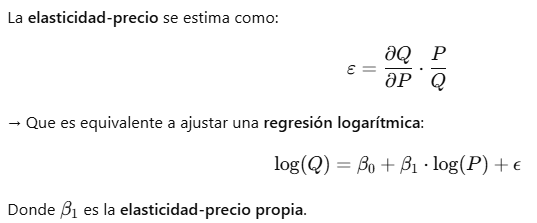

In [83]:
results_elasticity = {}

for sku in top_skus:
    df_sku = df[df['Sku_Id'] == sku].copy()

    df_sku['log_P'] = np.log(df_sku['Price'])
    df_sku['log_Q'] = np.log(df_sku['Units_Sold'])

    X = sm.add_constant(df_sku['log_P'])
    y = df_sku['log_Q']

    model = sm.OLS(y, X).fit()
    elasticity = model.params['log_P']
    pval = model.pvalues['log_P']

    results_elasticity[sku] = {
        'Elasticity': elasticity,
        'p-value': pval,
        'signif': "✓" if pval < 0.05 else "✗",
        'model':model
    }

for sku, result in results_elasticity.items():
    print(f"SKU {sku} → Elasticity: 1% ↑ Price → {result['Elasticity']:.2f}% ↓ Units Sold - p-value: {result['p-value']:.4f}, Signif: {result['signif']}")

SKU 726 → Elasticity: 1% ↑ Price → -2.24% ↓ Units Sold - p-value: 0.0000, Signif: ✓
SKU 850 → Elasticity: 1% ↑ Price → -2.08% ↓ Units Sold - p-value: 0.0007, Signif: ✓


### Forecasting

In [84]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import performance_metrics

results = {}
forecast_horizon = 6  # 6 months

for sku in top_skus:
    df_sku = df[df['Sku_Id'] == sku].copy()
    
    # Features
    X = df_sku[['Price']]
    y = df_sku['Units_Sold']
    
    # train-test (last 6 months for test)
    X_train, X_test = X[:-forecast_horizon], X[-forecast_horizon:]
    y_train, y_test = y[:-forecast_horizon], y[-forecast_horizon:]
    
    metrics = {}

    # Random Forest
    rf = RandomForestRegressor(n_estimators=50, random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    metrics['RandomForest'] = {
        'RMSE': root_mean_squared_error(y_test, y_pred_rf),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred_rf),
        'R2': r2_score(y_test, y_pred_rf),
        'Pred': y_pred_rf
    }

    # XGBoost 
    xgb = XGBRegressor(n_estimators=50, random_state=0)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    metrics['XGBoost'] = {
        'RMSE': root_mean_squared_error(y_test, y_pred_xgb),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred_xgb),
        'R2': r2_score(y_test, y_pred_xgb),
        'Pred': y_pred_xgb
    }

    # #  Holt-Winters 
    # hw = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12)
    # hw_fit = hw.fit()
    # y_pred_hw = hw_fit.forecast(forecast_horizon)
    # y_hw_all = hw_fit.fittedvalues.append(y_pred_hw)
    # metrics['HoltWinters'] = {
    #     'RMSE': root_mean_squared_error(y_test, y_pred_hw),
    #     'MAPE': mean_absolute_percentage_error(y_test, y_pred_hw),
    #     'R2': r2_score(y_test, y_pred_hw),
    #     'Forecast': y_hw_all
    # }

    # Prophet
    df_prophet = df_sku.reset_index().rename(columns={'Year_Month': 'ds', 'Units_Sold': 'y'})
    df_prophet = df_prophet[['ds', 'y']].copy()

    prophet_model = Prophet()
    prophet_model.fit(df_prophet[:-forecast_horizon])
    future = prophet_model.make_future_dataframe(periods=forecast_horizon, freq='MS')
    forecast = prophet_model.predict(future)
    y_pred_prophet = forecast[-forecast_horizon:]['yhat'].values
    full_forecast = forecast['yhat'].values[:-forecast_horizon]

    metrics['Prophet'] = {
        'RMSE': root_mean_squared_error(y_test, y_pred_prophet),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred_prophet),
        'R2': r2_score(y_test, y_pred_prophet),
        'Pred': y_pred_prophet
    }

    # Model competition
    metric_names = ['RMSE', 'MAPE', 'R2']
    model_names = list(metrics.keys())
    
    model_scores = {model: 0 for model in model_names}
    for metric in metric_names:
        if metric == 'R2':
            ranked_models = sorted(model_names, key=lambda m: metrics[m][metric], reverse=True)
        else:
            ranked_models = sorted(model_names, key=lambda m: metrics[m][metric])

        model_scores[ranked_models[0]] += 1
        model_scores[ranked_models[1]] += 1

    for model, score in model_scores.items():
        print(f"{model}: {score} points")

    # Select the best model (Who has more points)
    best_model = max(model_scores.items(), key=lambda x: x[1])[0]
    print(f"\nBest model: {best_model}")

    # Guardar resultados
    results[sku] = {
        'metrics': metrics,
        'best_model': best_model,
        'real': y,
        'forecast': metrics[best_model]['Pred']
    }


20:47:25 - cmdstanpy - INFO - Chain [1] start processing
20:47:26 - cmdstanpy - INFO - Chain [1] done processing


RandomForest: 3 points
XGBoost: 3 points
Prophet: 0 points

Best model: RandomForest


20:47:27 - cmdstanpy - INFO - Chain [1] start processing
20:47:27 - cmdstanpy - INFO - Chain [1] done processing


RandomForest: 3 points
XGBoost: 1 points
Prophet: 2 points

Best model: RandomForest


In [85]:
def fn_forecast(sku):
    df_sku = df[df['Sku_Id'] == sku].copy()
    df_sku['Year'] = pd.to_datetime(df_sku['Year_Month']).dt.year
    df_sku['Month'] = pd.to_datetime(df_sku['Year_Month']).dt.month


    X_price = df_sku[['Year', 'Month']]
    y_price = df_sku['Price']
    rf_price = RandomForestRegressor(n_estimators=50, random_state=0)
    rf_price.fit(X_price, y_price)

    future_dates = pd.date_range(start=pd.to_datetime(df_sku.Year_Month.max()) + pd.DateOffset(months=1), 
                                periods=forecast_horizon, freq='MS')

    df_future = pd.DataFrame({
        'Year_Month': future_dates.strftime('%Y-%m'),
        'Year': future_dates.year,
        'Month': future_dates.month
    }, index=future_dates)

    x_price_future = rf_price.predict(df_future[['Year', 'Month']])
    df_future['Price'] = x_price_future
    y_units_future = rf.predict(df_future[['Price']])
    df_future['Units_Sold'] = y_units_future
    df_future['Sku_Id'] = sku
    df_future = df_future.set_index('Year_Month')
    df_sku = df_sku.set_index('Year_Month')
    df_future = pd.concat([df_sku.tail(1), df_future], axis = 0)
    df_plot = pd.concat([df_sku, df_future], axis = 0)
    return df_sku, df_future, df_plot

In [86]:
def plot_forecast(sku,df_sku,df_future):
    plt.figure(figsize=(10, 5))
    plt.plot(df_sku['Units_Sold'], label='Historical')
    plt.plot(df_future['Units_Sold'], label='Forecast', linestyle='--')
    plt.title(f'Sku {sku}: Units_Sold Forecast with {results[sku]['best_model']}')
    plt.xlabel('Year_Month')
    plt.xticks(rotation=90)
    plt.ylabel('Units_Sold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

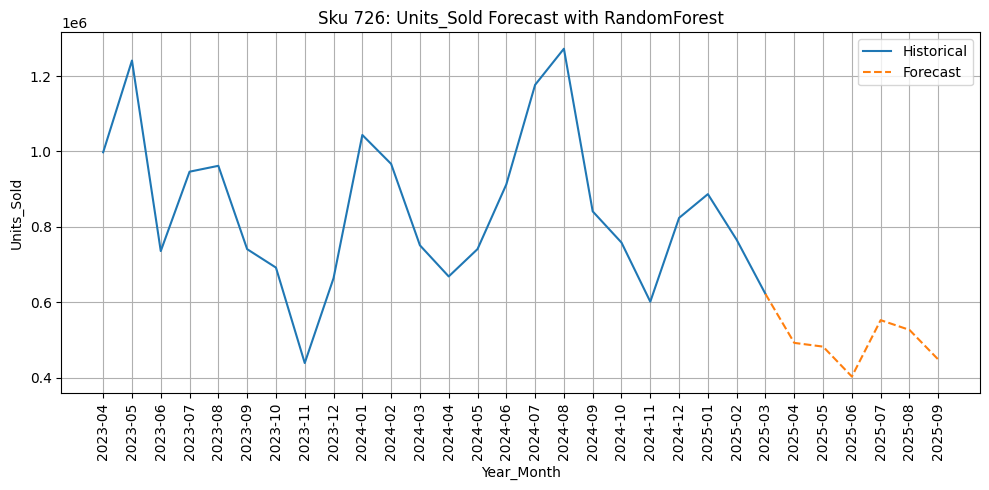

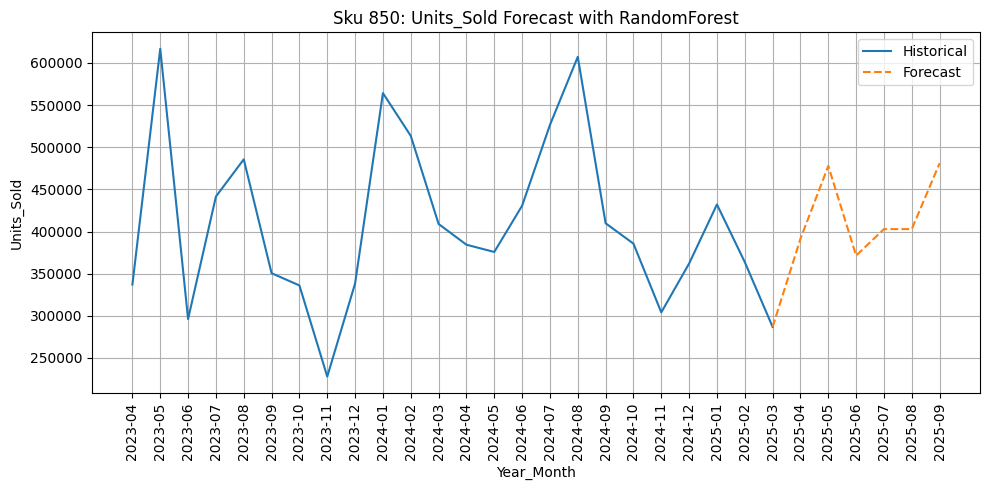

In [91]:
for sku in top_skus:
    df_sku, df_future, df_plot = fn_forecast(sku)
    plot_forecast(sku,df_sku,df_future)